## Inhaltsverzeichnis

1. **Einleitung**
2. **Benötigte Libraries**
3. **Datenverständnis**
4. **Datenaufbereitung**
5. **Modelbildung, Analyse und Interpretation**

## Einleitung

In diesem Notebook habe ich ein spannendes Data-Science-Projekt umgesetzt. Ziel dieses Projekts ist es, einen leistungsstarken Klassifikator zu entwickeln, der zuverlässig zwischen Bananen, Trauben und Äpfeln unterscheiden kann.

Folgende Kriterien sind zu erfüllen:

- Datenverständnis

- Datenaufbereitung

- Modelbildung, Analyse und Interpretation

## Benötigte-Libraries

- **matplotlib.pyplot**: Für die Erstellung von Visualisierungen.
- **seaborn**: Für erweiterte Datenvisualisierungen.
- **pandas**: Für die Datenmanipulation und -analyse.
- **train_test_split**: Zum Aufteilen der Daten in Trainings- und Testsets.
- **RandomForestClassifier**: Ein Klassifikator, der auf dem Random Forest-Algorithmus basiert.
- **accuracy_score, classification_report**: Zur Bewertung der Modellleistung.
- **StandardScaler**: Zur Standardisierung der Daten.
- **plot_tree**: Zur Visualisierung von Entscheidungsbäumen.

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree

## Datenverständnis

Bevor ich mit der Analyse beginne, überprüfe ich die Daten gründlich. Selbst sorgfältig aufbereitete Datensätze können Fehler enthalten. Es ist entscheidend, diese Fehler frühzeitig zu erkennen, bevor ich zu viel Zeit in die Analyse investiere.

Im Allgemeinen möchte ich dabei folgende Fragen beantworten:

- Gibt es irgendwelche Probleme mit den Daten?

- Gibt es Besonderheiten oder Auffälligkeiten in den Daten?

- Müsssen die Daten korrigiert oder entfernt werden?

In [75]:
file_path = 'C:/Users/Mazlum/Python_Project/PythonProject/data/fruit_data.xlsx' 
df = pd.read_excel(file_path)

print(df.head())
print(df.tail())
print(df.info())
print(df.describe())
print(df.isnull().sum())

   Unnamed: 0 fruit_type         color    size     weight
0           0      grape        Yellow    Tiny   8.303385
1           1      apple          Pink  Largee  80.976370
2           2     banana   Pale Yellow   Large  74.615192
3           3      grape           Red    Tiny   6.924070
4           4     banana  Creamy White  Largee  82.002542
     Unnamed: 0 fruit_type        color    size     weight
195         195      grape       Purple   Small   9.774546
196         196     banana  Pale Yellow   Large  39.012962
197         197      grape          Red   Small   7.409021
198         198      grape          Red  Medium   4.651554
199         199      grape          Red  Medium   5.937051
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   fruit_type  200 non-null    object 
 2   color       200 non-null 

Die Daten enthalten 200 vollständige Einträge mit 5 Spalten, darunter einen unnötigen Index (Unnamed: 0). Es gibt Tippfehler in der Spalte size (z.B „Largee“). Das Gewicht variiert stark , was auf unterschiedliche Fruchttypen und Größen hinweist. Für die Bereinigung sollten der Index entfernt und Schreibfehler korrigiert werden. Außerdem sieht man, dass die Gewichte auch fehlerhaft sind, da zum Beispiel Trauben die Rot und klein sind mehr wiegen als Trauben die ebenfalls Rot aber mittelgroß sind. 

## Datenaufbereitung

Ich habe zuerst die überflüssige Spalte Unnamed: 0 aus dem DataFrame entfernt, da sie nur einen redundanten Index darstellt und keine relevanten Informationen enthält. Anschließend habe ich die Häufigkeiten der Werte in drei Spalten gezählt, um einen schnellen Überblick über die Verteilung der Daten zu bekommen.

In [76]:
fruit_data_cleaned = df.drop(columns=["Unnamed: 0"])

fruit_type_counts = fruit_data_cleaned["fruit_type"].value_counts()
color_counts = fruit_data_cleaned["color"].value_counts()
size_counts = fruit_data_cleaned["size"].value_counts()

fruit_type_counts, color_counts, size_counts

(fruit_type
 apple     70
 grape     66
 banana    64
 Name: count, dtype: int64,
 color
 Green           58
 Yellow          43
 Red             31
 Creamy White    17
 Pink            17
 Purple          13
 Black           10
 Pale Yellow      9
 Yellow1          2
 Name: count, dtype: int64,
 size
 Small     57
 Medium    52
 Large     39
 Largee    29
 Tiny      23
 Name: count, dtype: int64)

Zusammengefasst zeigen die Daten eine insgesamt gute Verteilung, aber kleinere Probleme wie Schreibfehler („Largee“ und „Yellow1“) und inkonsistente Farbangaben sollten vor der weiteren Analyse bereinigt werden.




Hier bereinige ich dann die Spalten color und size, indem die inkonsistenten oder fehlerhaften Einträge ersetzt werden. Dadurch werden die Daten einheitlicher.

Zum Abschluss habe ich die Häufigkeiten der bereinigten Farb- und Größenwerte mit value_counts() erneut berechnet und gespeichert, um die aktualisierte Verteilung zu überprüfen. Die bereinigten Daten sind nun einheitlicher und bereit für die weitere Analyse.

In [77]:
fruit_data_cleaned["color"] = fruit_data_cleaned["color"].replace({
    "Yellow1": "Yellow",
    "Pale Yellow": "Yellow",
    "Creamy White": "White"
})

fruit_data_cleaned["size"] = fruit_data_cleaned["size"].replace({
    "Largee": "Large"
})

color_counts_corrected = fruit_data_cleaned["color"].value_counts()
size_counts_corrected = fruit_data_cleaned["size"].value_counts()

color_counts_corrected, size_counts_corrected

(color
 Green     58
 Yellow    54
 Red       31
 Pink      17
 White     17
 Purple    13
 Black     10
 Name: count, dtype: int64,
 size
 Large     68
 Small     57
 Medium    52
 Tiny      23
 Name: count, dtype: int64)

Um eine logischere Gewichtsverteilung zu schaffen und potenzielle fehlerhafte Werte zur berücksichtigen, verwende ich das Vorgehen mit dem 25%- und 75% Quantil. Damit ich mir dann die neuen Kennzahlen, wie z.B. minimale Werte und maximale Werte ansehen kann, gruppiere ich anhand der Spalten fruit_type, color und size und berücksichtige dabei nur die Spalte weight.

In [78]:
fruit_stats_old_label = fruit_data_cleaned.groupby(['fruit_type','color', 'size'])['weight'].agg(
	mean='mean',
	std='std',
	count='count',
	min='min',
	max='max',
	median='median',
	q25=lambda x: x.quantile(0.25),
	q75=lambda x: x.quantile(0.75)
)


In der Übersicht sieht man genau, dass das labeling keinen Sinn macht. Ein Apfel der grün und large ist, hat ein min-Gewicht von 43 wobei medium bei 8 liegt. Dies wiederholt sich auch in den anderen Früchten und deren Farben. Dieses Problem müssen wir lösen.

In [79]:
fruit_stats_old_label

mean         std  count         min  \
fruit_type color  size                                                
apple      Green  Large    91.009963   28.484043     11   43.287969   
                  Medium   81.105637   42.342566      5    8.300753   
                  Small   129.902670   56.252273      7   81.298242   
           Pink   Large    90.021492   24.516415     10   50.577337   
                  Medium   96.203474   19.026724      3   85.188980   
                  Small    82.084756   28.133975      4   43.287969   
           Red    Large    70.274352   30.083498      7   25.038323   
                  Medium   74.280293   38.735466      4   25.038323   
                  Small    89.043116   23.586221      6   43.287969   
           Yellow Large   102.074042   19.353537      8   68.720254   
                  Medium  120.095383  116.459019      3   25.038323   
                  Small   113.550979   24.283302      2   96.380092   
banana     Green  Large    65.837487   27.039134     12   26.524587   
                  Medium   94.060059   26.937867      4   56.056490   
                  Small    82.837054   30.950581      4   46.145790   
           White  Large    86.924490   12.983888      3   77.121200   
                  Medium   76.523382   11.739667      5   57.498575   
                  Small    67.242012   35.237675      9   32.326450   
           Yellow Large    77.856080   26.114046     17   32.326450   
                  Medium   68.512337   32.282760      9   26.524587   
                  Small   107.777918         NaN      1  107.777918   
grape      Black  Medium    6.300760    0.458372      4    5.717561   
                  Small     5.602942    1.101157      4    4.651554   
                  Tiny      6.554330    0.130707      2    6.461906   
           Green  Medium    6.916196    1.980642      6    5.822353   
                  Small     7.704103    2.685162      6    4.309718   
                  Tiny      6.645194    1.745143      3    4.824471   
           Purple Medium    5.874270    1.484641      2    4.824471   
                  Small     8.249588    1.763376      6    5.822353   
                  Tiny      8.450414    2.644417      5    4.309718   
           Red    Medium    6.367081    1.358240      4    4.651554   
                  Small     7.495597    0.149953      3    7.409021   
                  Tiny      6.973172    1.566419      7    4.651554   
           Yellow Medium    5.195506    1.118457      3    4.309718   
                  Small     6.071306    0.833362      5    5.371310   
                  Tiny      6.717314    3.203948      6    1.000000   

                                 max      median         q25         q75  
fruit_type color  size                                                    
apple      Green  Large   130.721867   85.247827   72.036243  118.957169  
                  Medium  118.173616   92.592654   87.272178   99.188985  
                  Small   250.000000  118.173616   99.425433  130.497984  
           Pink   Large   130.721867   87.005709   75.200113  102.852112  
                  Medium  118.173616   85.247827   85.218403  101.710722  
                  Small   108.034470   88.508293   71.554270   99.038779  
           Red    Large   108.034470   68.720254   50.577337   94.486373  
                  Medium  118.173616   76.954617   57.799771   93.435139  
                  Small   108.034470   92.314245   92.035836  102.852112  
           Yellow Large   130.721867  101.326012   92.578934  110.471047  
                  Medium  250.000000   85.247827   55.143075  167.623914  
                  Small   130.721867  113.550979  104.965535  122.136423  
banana     Green  Large   109.376273   63.906294   44.377455   90.648888  
                  Medium  116.374841  101.904453   84.838597  111.125915  
                  Small   116.380543   84.410941   64.271957  102.976038  
           White  Large   101.649728   82.002542   79.5618

Nun hat man eine klare Übersicht über die Gewichtsverteilung, aufgeschlüsselt nach Fruchttyp und deren Farbe. Dabei ist es besonders wichtig, die Kennzahlen für jede Farbe einer Frucht separat zu berechnen, da die Farbe möglicherweise Einfluss darauf hat, wie groß oder schwer eine Frucht in der expliziten Farbe typischerweise sein kann.




Damit wir jetzt eine Gewichtsverteilung machen können, müssen wir bestimmen, ab wann eine Frucht als klein, mittelgroß oder groß gilt. Ganz am Anfang gab es noch die Größe "Tiny" die wir in dieser Lösung ebenfalls als klein "small" berücksichtigen. Abschließend visualisieren wir die Ergebnisse, um die neue Gewichtsverteilung anschaulich darzustellen und einen klaren Überblick über die neu definierten Größenklassen zu erhalten.

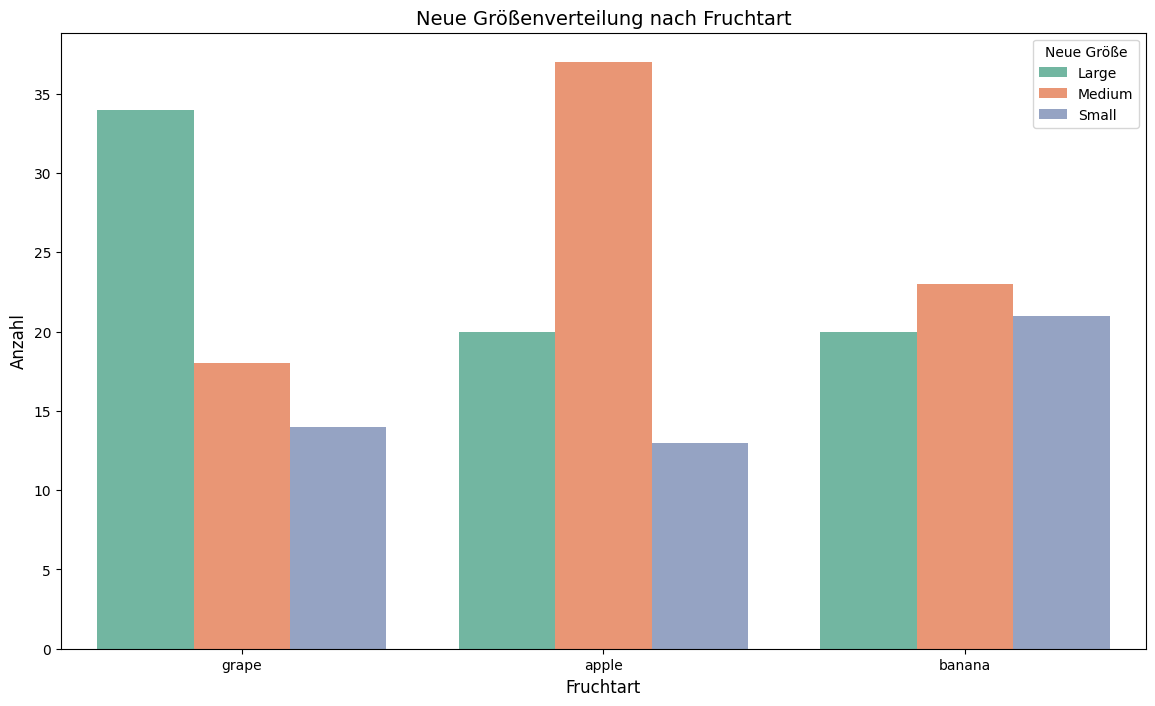

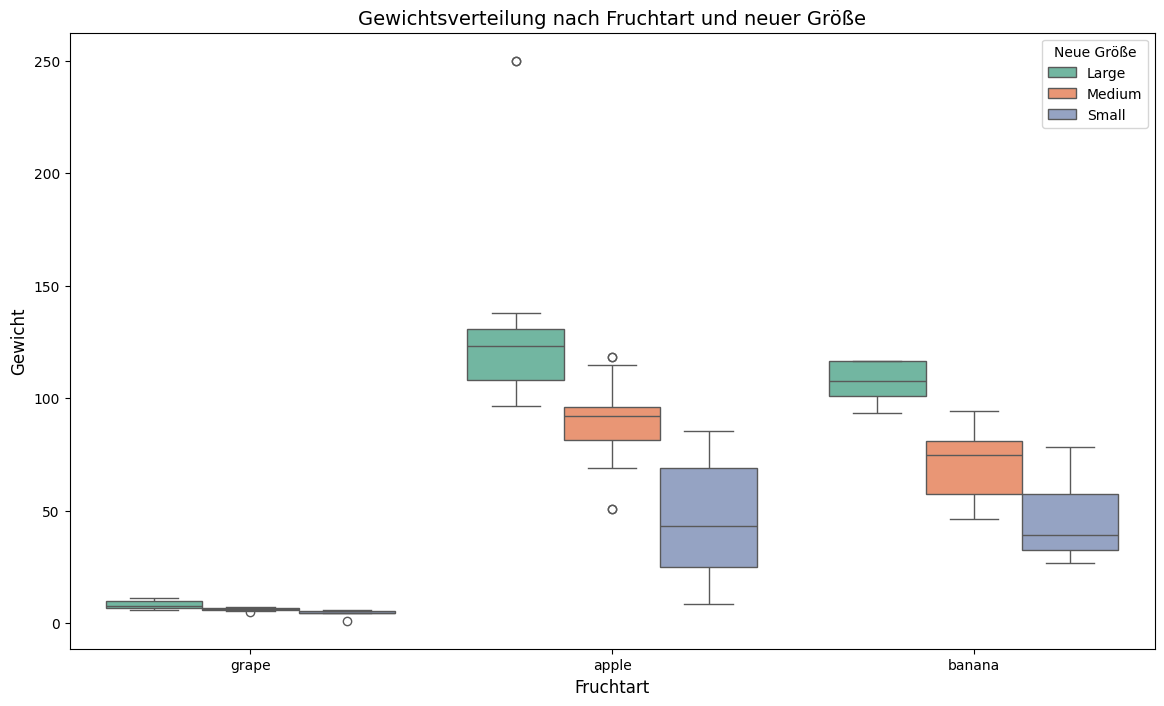

In [80]:
fruit_stats =fruit_stats_old_label.reset_index()

def assign_size_by_quantiles(row, stats):
    fruit_type = row['fruit_type']
    color = row['color']
    weight = row['weight']
    
    stats_row = stats[(stats['fruit_type'] == fruit_type) & (stats['color'] == color)].iloc[0]
    
    if weight < stats_row['q25']:
        return 'Small'
    elif weight < stats_row['q75']:
        return 'Medium'
    else:
        return 'Large'

fruit_data_cleaned['new_size'] = fruit_data_cleaned.apply(lambda row: assign_size_by_quantiles(row, fruit_stats), axis=1)

plt.figure(figsize=(14, 8))
sns.countplot(data=fruit_data_cleaned, x="fruit_type", hue="new_size", palette="Set2")
plt.title("Neue Größenverteilung nach Fruchtart", fontsize=14)
plt.xlabel("Fruchtart", fontsize=12)
plt.ylabel("Anzahl", fontsize=12)
plt.legend(title="Neue Größe", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

plt.figure(figsize=(14, 8))
sns.boxplot(data=fruit_data_cleaned, x="fruit_type", y="weight", hue="new_size", palette="Set2")
plt.title("Gewichtsverteilung nach Fruchtart und neuer Größe", fontsize=14)
plt.xlabel("Fruchtart", fontsize=12)
plt.ylabel("Gewicht", fontsize=12)
plt.legend(title="Neue Größe", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


## Modelbildung, Analyse & Interpretation

Jetzt gehen wir rüber zu der Modelbildung und Analyse. Zunächst müssen wir die Daten für das Lernmodell vorbereiten. Da wir eine neue Größenverteilung (new_size) haben (ohne Tiny) brauchen wir die Spalte "size" nicht mehr. x sind unsere unabhängigen Variablen, deshalb entfernen wir unsere Abhängige Variable fruit_type weil es  unsere Zielvariable y ist, die wir in numerische Werte umwandeln, da maschinelle Lernmodelle numerische Werte für die Zielvariable erwarten (Hot encoding).

Um die Leistungsfähigkeit eines maschinellen Lernmodells zu bewerten und Überanpassung (Overfitting) zu vermeiden, teilen wir die Trainings- und Testdaten auf.

Dann müssen wir noch die kategorialen Variablen in numerische Dummy-Variablen umwandeln, da Modelle wie Decision Tree oder neuronale Netze in der Regel nur mit numerischen Daten arbeiten können. Außerdem verhindern wir Redundanz, indem die erste Kategorie jeder Variable weggelassen wird.

In [81]:
fruit_data_cleaned = fruit_data_cleaned.drop(columns=["size"])

x = fruit_data_cleaned.drop(columns=['fruit_type'])
y = fruit_data_cleaned['fruit_type'].map({'apple': 0, 'grape': 1, 'banana': 2})

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

Jetzt sind wir so weit, dass wir mit dem ersten Modell "Random Forest Classifier" anfangen können. Da wir davor unsere Daten aufgeteilt haben in Test und Trainingsdaten, können wir diese jetzt für das Modell verwenden.

In [82]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_encoded, y_train)

y_pred_rf = rf_model.predict(X_test_encoded)

rf_report = classification_report(y_test, y_pred_rf, target_names=['apple', 'grape', 'banana'])
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print("Random Forest: Modellleistung")
print(f"Genauigkeit: {rf_accuracy:.2f}")
print(f"Klassifikationsbericht:\n{rf_report}")

Random Forest: Modellleistung
Genauigkeit: 0.92
Klassifikationsbericht:
              precision    recall  f1-score   support

       apple       1.00      0.76      0.86        21
       grape       0.95      1.00      0.98        20
      banana       0.83      1.00      0.90        19

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.91        60



Das Random-Forest-Modell zeigt insgesamt eine sehr gute Leistung mit einer Genauigkeit von 92%, was bedeutet, dass 92% unserer Testdaten korrekt klassifiziert wurden. Für „apple“ ist die Precision mit 1.00 perfekt, das heißt, alle als „apple“ klassifizierten Früchte sind tatsächlich Äpfel. Der Recall von 0.76 zeigt jedoch, dass das Modell 76% der tatsächlichen Äpfel korrekt erkennt, was darauf hindeutet, dass einige übersehen wurden. Für „grape“ und „banana“ liegt der Recall bei 100%, was bedeutet, dass alle Trauben und Bananen korrekt erkannt werden. Die Precision ist für „grape“ mit 0.95 sehr hoch, während sie für „banana“ mit 0.83 etwas niedriger ausfällt, was darauf hinweist, dass einige Früchte fälschlicherweise als Bananen klassifiziert wurden. Der F1-Score ist für alle Klassen gut, zeigt aber bei „apple“ leichte Schwächen aufgrund des geringeren Recalls.

**Versuchen wir mal das Modell mit Hyperparamter-Tuning**:

Mit Hyperparameter steuert man die Funktionsweise eines Random-Forest-Modells, um es optimal an die Daten anzupassen. **n_estimators** legt fest, wie viele Entscheidungsbäume im Wald enthalten sind, wobei eine höhere Anzahl die Genauigkeit steigert, aber mehr Rechenleistung erfordert. **max_depth** begrenzt die Tiefe der Bäume, um Overfitting zu verhindern und die Generalisierungsfähigkeit zu verbessern. **min_samples_split** und **min_samples_leaf** sorgen dafür, dass ein Knoten nur geteilt oder ein Blatt erstellt wird, wenn genügend Datenpunkte vorhanden sind, was das Modell stabiler macht und Rauschen reduziert. Dadurch wird eine Balance zwischen Genauigkeit und Modellkomplexität erreicht.


Durch das Anpassen der Hyperparameter kann man das Modell flexibler oder restriktiver machen. Höhere Werte fördern die Generalisierung und Stabilität, während niedrigere Werte die Anpassung an feinere Details erlauben, aber das Risiko von Overfitting erhöhen. Die Wahl der richtigen Werte hängt von den spezifischen Daten und Anforderungen ab.

In [83]:
best_params_rf = {'n_estimators': 300, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 2}

rf_model_tuned = RandomForestClassifier(**best_params_rf, random_state=42)
rf_model_tuned.fit(X_train_encoded, y_train)

y_pred_rf_tuned = rf_model_tuned.predict(X_test_encoded)

rf_report_tuned = classification_report(y_test, y_pred_rf_tuned, target_names=['apple', 'grape', 'banana'])
rf_accuracy_tuned = accuracy_score(y_test, y_pred_rf_tuned)

print("Random Forest (Tuned): Modellleistung")
print(f"Genauigkeit: {rf_accuracy_tuned:.2f}")
print(f"Klassifikationsbericht:\n{rf_report_tuned}")

Random Forest (Tuned): Modellleistung
Genauigkeit: 0.87
Klassifikationsbericht:
              precision    recall  f1-score   support

       apple       0.93      0.67      0.78        21
       grape       0.95      1.00      0.98        20
      banana       0.75      0.95      0.84        19

    accuracy                           0.87        60
   macro avg       0.88      0.87      0.86        60
weighted avg       0.88      0.87      0.86        60



Das getunte Modell ist insgesamt etwas weniger genau, da die Genauigkeit von 0.92 auf 0.87 gesunken ist. Besonders bei „apple“ und „banana“ zeigen sich Verschlechterungen, während „grape“ stabil bleibt. Dies deutet darauf hin, dass das ursprüngliche Modell möglicherweise überangepasst war. Das Tuning hat das Modell generalisierungsfähiger gemacht, was für zukünftige unbekannte Daten von Vorteil sein könnte, auch wenn die unmittelbare Leistung auf den Testdaten geringer ist. Weitere Feinanpassungen könnten helfen, die Balance zwischen Generalisierung und Genauigkeit zu verbessern.


**Versuchen wir es mal mit dem Modell LogisticRegression**:

In [84]:
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

best_params = {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

logistic_model_tuned = LogisticRegression(**best_params, max_iter=500, random_state=42)
logistic_model_tuned.fit(X_train_scaled, y_train)

y_pred_logistic_tuned = logistic_model_tuned.predict(X_test_scaled)

logistic_report_tuned = classification_report(y_test, y_pred_logistic_tuned, target_names=['apple', 'grape', 'banana'])
logistic_accuracy_tuned = accuracy_score(y_test, y_pred_logistic_tuned)

print("Logistische Regression (Tuned): Modellleistung")
print(f"Genauigkeit: {logistic_accuracy_tuned:.2f}")
print(f"Klassifikationsbericht:\n{logistic_report_tuned}")

Logistische Regression (Tuned): Modellleistung
Genauigkeit: 0.92
Klassifikationsbericht:
              precision    recall  f1-score   support

       apple       0.94      0.81      0.87        21
       grape       0.95      1.00      0.98        20
      banana       0.86      0.95      0.90        19

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



Die Logistische Regression liefert mit einer Genauigkeit von 92% eine sehr gute Leistung, ähnlich mit der ursprünglichen Version des Random-Forest-Modells ohne HyperParameter-Tuning. Die Werte zeigen eine sehr konsistente Leistung über alle Klassen hinweg. Besonders die Ergebnisse für "grape" sind außerordentlich gut (Recall von 1.00, F1-Score von 0.98). Das Modell ist weniger anfällig für Überanpassung als der Random Forest und bietet dennoch eine ähnliche Genauigkeit.

**Als nächstes versuchen wir es noch mit dem DecisionTreeClassifier**:

Entscheidungsbaum: Modellleistung


### Genauigkeit: 0.92

### Klassifikationsbericht:
```
              precision    recall  f1-score   support

       apple       1.00      0.76      0.86        21
       grape       0.95      1.00      0.98        20
      banana       0.83      1.00      0.90        19

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.91        60

```

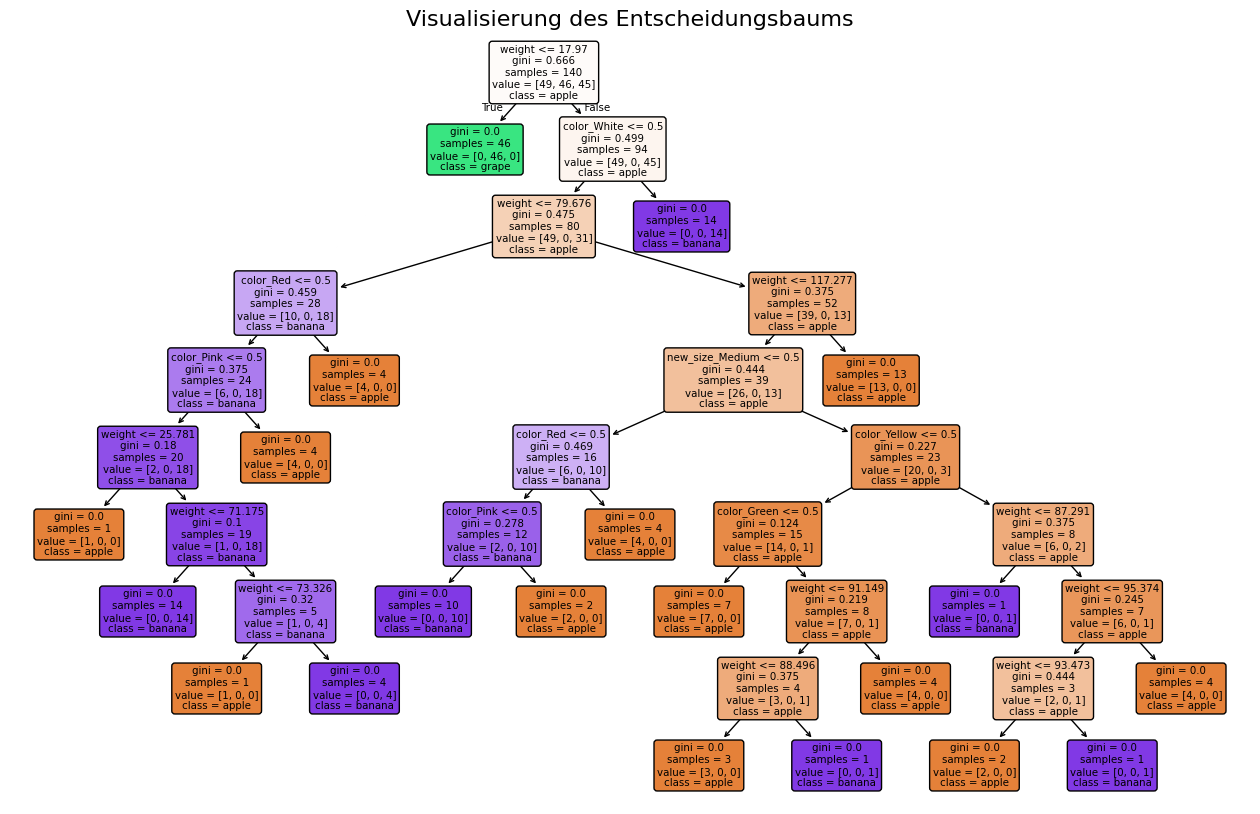

In [85]:
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display, Markdown

decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train_encoded, y_train)

y_pred_tree = decision_tree_model.predict(X_test_encoded)

tree_report = classification_report(y_test, y_pred_tree, target_names=['apple', 'grape', 'banana'])
tree_accuracy = accuracy_score(y_test, y_pred_tree)

print("Entscheidungsbaum: Modellleistung")
display(Markdown(f"### Genauigkeit: {tree_accuracy:.2f}"))
display(Markdown(f"### Klassifikationsbericht:\n```\n{tree_report}\n```"))

plt.figure(figsize=(16, 10))
plot_tree(decision_tree_model, feature_names=X_train_encoded.columns, class_names=['apple', 'grape', 'banana'], filled=True, rounded=True)
plt.title("Visualisierung des Entscheidungsbaums", fontsize=16)
plt.show()

Der DecisionTreeClassifier zeigt ebenfalls eine sehr gute Leistung mit einer Genauigkeit von 92% und relativ ausgewogenen Metriken. Es ist ähnlich wie bei der Logistischen Regression (92%) und der ursprünglichen Random-Forest-Version, bleibt aber ein leistungsfähiges Modell. Wir sind wieder Werte die sich zwischen 0.9 und 1.0 bewegen, außer der Recall für Äpfel mit 0.76, was darauf hinweist, dass das Modell Schwierigkeiten hat, alle Äpfel korrekt zu erkennen.


In der Visualisierung sieht man, dass man bei diesem Modell eine klar und interpretierbare Struktur hat, was ein Vorteil gegenüber komplexeren Modellen wie Random-Forests oder neuronalen Netzen bietet. Allerdings zeigt die hohe Abhängigkeit von bestimmten Schwellenwerten, dass das Modell empfindlich auf Änderungen in den Daten sein könnte **(Overfitting)**.

In [86]:
print("Logistic Regression (Tuned) Accuracy:", logistic_accuracy_tuned)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest (Tuned) Accuracy:", rf_accuracy_tuned)
print("Decision Tree Accuracy:", tree_accuracy)

Logistic Regression (Tuned) Accuracy: 0.9166666666666666
Random Forest Accuracy: 0.9166666666666666
Random Forest (Tuned) Accuracy: 0.8666666666666667
Decision Tree Accuracy: 0.9166666666666666


Damit wir eine Übersicht über alle Modelle und deren Ergebnisse haben, erstelle ich noch eine Tabelle mit allen Werten.

In [87]:
reports = {
    "Logistic Regression (Tuned)": logistic_report_tuned,
    "Decision Tree": tree_report,
    "Random Forest (Tuned)": rf_report_tuned,
    "Random Forest": rf_report
}

def parse_classification_report(report_str):
    report_data = []
    lines = report_str.split('\n')
    for line in lines[2:-3]:
        row_data = line.split()
        if len(row_data) >= 3:  
            if row_data[0].strip() == 'accuracy':
                row = {'Class': row_data[0], 'Precision': None, 'Recall': None,
                       'F1-Score': float(row_data[1]), 'Support': int(row_data[2])}
            else:  
                row = {
                    'Class': row_data[0],
                    'Precision': float(row_data[1]),
                    'Recall': float(row_data[2]),
                    'F1-Score': float(row_data[3]),
                    'Support': int(row_data[4])
                }
            report_data.append(row)
    return report_data


rows = []

for model_name, report in reports.items():
    parsed_report = parse_classification_report(report)
    for metrics in parsed_report:
        rows.append({
            'Model': model_name,
            'Class': metrics['Class'],
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall'],
            'F1-Score': metrics['F1-Score'],
            'Support': metrics['Support']
        })

comparison_df = pd.DataFrame(rows)

import ace_tools_open as tools; tools.display_dataframe_to_user(name="Model Comparison Report", dataframe=comparison_df)


Model Comparison Report
